In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# planeExtract

In [3]:
import __getMetrics

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

metricsFilePath = "planeExtract_distance_threshold_0p5_inlierThreshold_0p1_num_iterations_50_Metrics.txt"
metricsFile = resultsPath + metricsFilePath 
metricsDF = pd.read_csv(metricsFile)
results0p1 = __getMetrics.group_by_constructions(metricsDF)

metricsFilePath = "planeExtract_distance_threshold_0p5_inlierThreshold_0p15_num_iterations_50_Metrics.txt"
metricsFile = resultsPath + metricsFilePath 
metricsDF = pd.read_csv(metricsFile)
results0p15 = __getMetrics.group_by_constructions(metricsDF)

metricsFilePath = "planeExtract_distance_threshold_0p5_inlierThreshold_0p3_num_iterations_50_Metrics.txt"
metricsFile = resultsPath + metricsFilePath 
metricsDF = pd.read_csv(metricsFile)
results0p3 = __getMetrics.group_by_constructions(metricsDF)

In [8]:
print("0p1:", results0p1.avg_silhouette.mean())
print("0p15:", results0p15.avg_silhouette.mean())
print("0p3:", results0p3.avg_silhouette.mean())

0p1: 0.6467019835089867
0p15: 0.648452583045625
0p3: 0.62341835946562


In [9]:
print("0p1:", results0p1.avg_silhouette.median())
print("0p15:", results0p15.avg_silhouette.median())
print("0p3:", results0p3.avg_silhouette.median())

0p1: 0.7169898034778828
0p15: 0.7086889728595073
0p3: 0.6644427437222398


In [24]:
difference = (results0p1.avg_silhouette - results0p15.avg_silhouette) > 0
print("0.1 outperforms in: ", len(difference[difference]))
print("0.15 outperforms in: ",len(difference[~difference]))

0.1 outperforms in:  33
0.15 outperforms in:  21


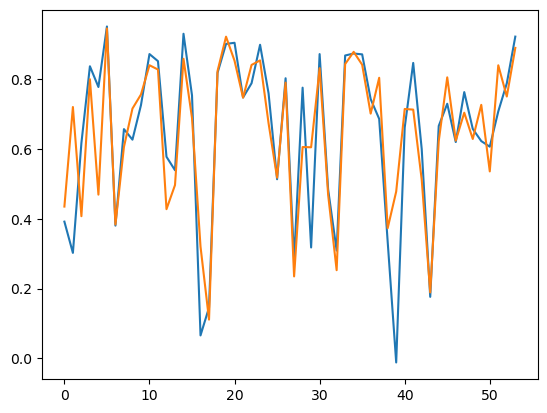

In [14]:
plt.plot(results0p1.avg_silhouette)
plt.plot(results0p15.avg_silhouette)


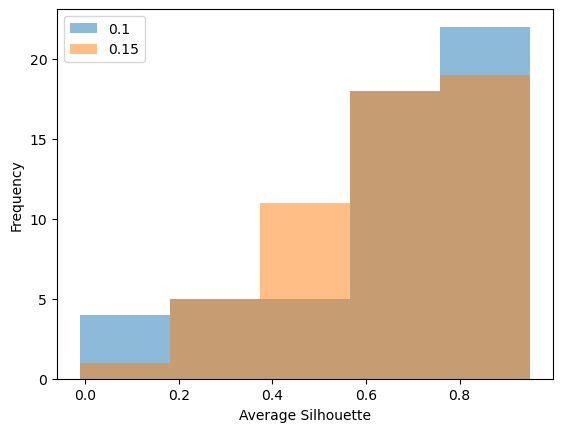

In [31]:
# Combine data to determine common bin edges
all_data = np.concatenate([results0p1.avg_silhouette, results0p15.avg_silhouette])

# Create 10 bins spanning the combined range
bins = np.linspace(all_data.min(), all_data.max(), 6)  # 10 bins => 11 edges

# Plot histograms with the same bins
plt.hist(results0p1.avg_silhouette, bins=bins, alpha=0.5, label='0.1')
plt.hist(results0p15.avg_silhouette, bins=bins, alpha=0.5, label='0.15')

plt.legend()
plt.xlabel('Average Silhouette')
plt.ylabel('Frequency')
plt.show()


# Shading vs no Shading

In [2]:
import os
import geopandas as gpd

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"
experiment = "0_Results_for_paper_planeExtract_0p1_Shaded_30cmMesh"
parcelsFolder = resultsPath + experiment + "/"
solarGDF_list = []

for parcel in os.listdir(parcelsFolder):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction + "/"
        solarGDF = gpd.read_file(constructionFolder + "Solar Estimation Panels Simulated/" + construction + ".gpkg")
        solarGDF_list.append(solarGDF)

combined_gdf_Shaded = gpd.GeoDataFrame(pd.concat(solarGDF_list, ignore_index=True))
combined_gdf_Shaded["AC_Yearly"].mean()

np.float64(470.76802684954146)

In [3]:
import os
import geopandas as gpd

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"
experiment = "0_Results_for_paper_planeExtract_0p1_Unshaded"
parcelsFolder = resultsPath + experiment + "/"
solarGDF_list = []

for parcel in os.listdir(parcelsFolder):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction + "/"
        solarGDF = gpd.read_file(constructionFolder + "Solar Estimation Panels Simulated/" + construction + ".gpkg")
        solarGDF_list.append(solarGDF)

combined_gdf_Unshaded = gpd.GeoDataFrame(pd.concat(solarGDF_list, ignore_index=True))
combined_gdf_Unshaded["AC_Yearly"].mean()

np.float64(487.154825161088)

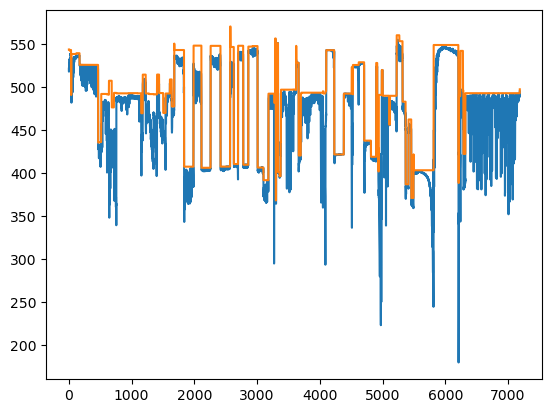

In [19]:
combinedGDF_comparison = pd.concat([combined_gdf_Shaded, combined_gdf_Unshaded], axis=1, ignore_index=True, sort=False)
combinedGDF_comparison = combinedGDF_comparison.rename(columns={0:"AC_Shaded", 4: "AC_Unshaded"})
combinedGDF_comparison["RemainingEnergy"] = combinedGDF_comparison["AC_Shaded"]/combinedGDF_comparison["AC_Unshaded"]
combinedGDF_comparison["LossRatio"] = 1 - combinedGDF_comparison["RemainingEnergy"]
combinedGDF_comparison
plt.plot(combinedGDF_comparison["AC_Shaded"])
plt.plot(combinedGDF_comparison["AC_Unshaded"])

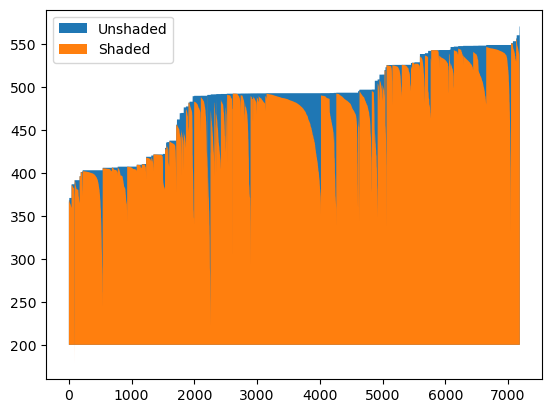

In [20]:
sorted_combinedGDF_comparison = combinedGDF_comparison.sort_values(["AC_Unshaded", "LossRatio"]).reset_index(drop=True)
plt.fill_between(
    range(len(sorted_combinedGDF_comparison["AC_Unshaded"])),
    200,
    sorted_combinedGDF_comparison["AC_Unshaded"],
    label="Unshaded"
)
plt.fill_between(
    range(len(sorted_combinedGDF_comparison["AC_Shaded"])),
    200,
    sorted_combinedGDF_comparison["AC_Shaded"],
    label="Shaded"
)
plt.legend()

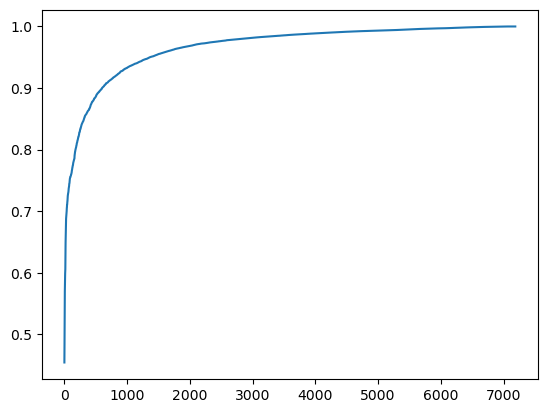

In [32]:
resorted_combinedGDF_comparison = sorted_combinedGDF_comparison.sort_values(["RemainingEnergy"]).reset_index(drop=True)
plt.plot(resorted_combinedGDF_comparison["RemainingEnergy"])

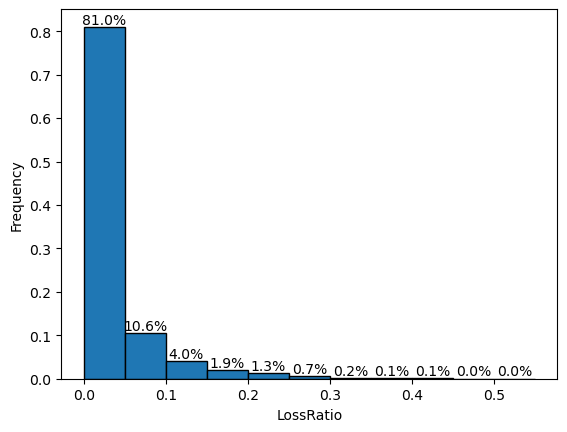

In [34]:
import numpy as np
min_val = combinedGDF_comparison["LossRatio"].min()
max_val = combinedGDF_comparison["LossRatio"].max()
bins = np.arange(min_val, max_val + 0.05, 0.05)

# Compute histogram
hist, edges = np.histogram(combinedGDF_comparison["LossRatio"], bins=bins)
freq = hist / float(hist.sum())

# Plot
width = np.diff(edges)  # This will all be 0.05
plt.bar(edges[:-1], freq, width=width, align="edge", ec="k")

# Add frequency labels above bars
for x, y in zip(edges[:-1], freq):
    if y > 0:  # only label non-empty bins
        plt.text(x + width[0] / 2, y, f"{100*y:.1f}%", ha="center", va="bottom")

plt.xlabel("LossRatio")
plt.ylabel("Frequency")
plt.show()

In [18]:
np.max(combinedGDF_comparison["LossRatio"])

1.0

In [95]:
sorted_combinedGDF_comparison

,AC_Shaded,1,2,3,AC_Unshaded,5,6,7,LossRatio
0,366.632080,387.334861,2402.232790,"POLYGON ((434003.877 4585269.028, 434004.539 4...",367.973912,388.726318,2410.995627,"POLYGON ((434003.877 4585269.028, 434004.539 4...",0.996353
1,366.802024,387.511048,2403.204097,"POLYGON ((434001.227 4585271.693, 434001.889 4...",367.973912,388.726318,2410.995627,"POLYGON ((434001.227 4585271.693, 434001.889 4...",0.996815
2,366.707904,387.413471,2402.702553,"POLYGON ((434002.552 4585270.36, 434003.214 45...",367.973912,388.726318,2410.995627,"POLYGON ((434002.552 4585270.36, 434003.214 45...",0.996560
3,366.567896,387.268319,2401.777988,"POLYGON ((434005.202 4585267.695, 434005.864 4...",367.973912,388.726318,2410.995627,"POLYGON ((434005.202 4585267.695, 434005.864 4...",0.996179
4,366.201671,386.888972,2399.624715,"POLYGON ((434010.501 4585262.365, 434011.163 4...",367.973912,388.726318,2410.995627,"POLYGON ((434010.501 4585262.365, 434011.163 4...",0.995184
...,...,...,...,...,...,...,...,...,...
7184,559.500175,587.287378,3588.760950,"POLYGON ((434045.117 4584894.157, 434045.105 4...",570.289692,598.473406,3662.553067,"POLYGON ((434045.117 4584894.157, 434045.105 4...",0.981081
7185,549.728472,577.156704,3529.048262,"POLYGON ((434045.105 4584893.209, 434045.092 4...",570.289692,598.473406,3662.553067,"POLYGON ((434045.105 4584893.209, 434045.092 4...",0.963946
7186,558.121463,585.858018,3580.271754,"POLYGON ((434043.238 4584894.181, 434043.226 4...",570.289692,598.473406,3662.553067,"POLYGON ((434043.238 4584894.181, 434043.226 4...",0.978663
7187,549.743130,577.171901,3529.073224,"POLYGON ((434043.226 4584893.233, 434043.214 4...",570.289692,598.473406,3662.553067,"POLYGON ((434043.226 4584893.233, 434043.214 4...",0.963972


# Shading1M vs Shading0.3M

In [105]:
import os
import geopandas as gpd

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"
experiment = "0_Results_for_paper_planeExtract_0p1_Shaded"
parcelsFolder = resultsPath + experiment + "/"
solarGDF_list = []

for parcel in os.listdir(parcelsFolder):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction + "/"
        solarGDF = gpd.read_file(constructionFolder + "Solar Estimation Panels Simulated/" + construction + ".gpkg")
        solarGDF_list.append(solarGDF)

combined_gdf_Shaded = gpd.GeoDataFrame(pd.concat(solarGDF_list, ignore_index=True))
combined_gdf_Shaded["AC_Yearly"].mean()

np.float64(479.2103291116717)

In [106]:
import os
import geopandas as gpd

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"
experiment = "0_Results_for_paper_planeExtract_0p1_Shaded_30cmMesh"
parcelsFolder = resultsPath + experiment + "/"
solarGDF_list = []

for parcel in os.listdir(parcelsFolder):
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction + "/"
        solarGDF = gpd.read_file(constructionFolder + "Solar Estimation Panels Simulated/" + construction + ".gpkg")
        solarGDF_list.append(solarGDF)

combined_gdf_fine = gpd.GeoDataFrame(pd.concat(solarGDF_list, ignore_index=True))
combined_gdf_fine["AC_Yearly"].mean()

np.float64(470.76802684954146)

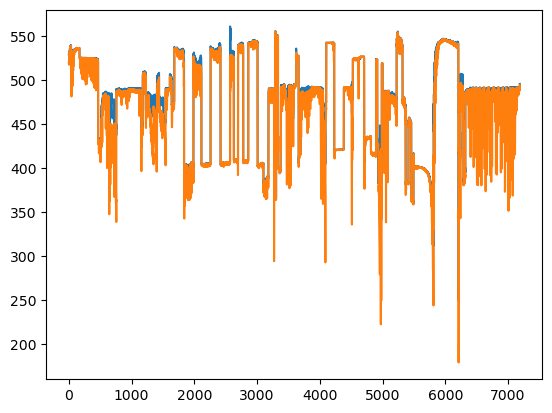

In [107]:
combinedGDF_comparison = pd.concat([combined_gdf_Shaded, combined_gdf_fine], axis=1, ignore_index=True, sort=False)
combinedGDF_comparison = combinedGDF_comparison.rename(columns={0:"AC_Shaded", 4: "AC_fine"})
combinedGDF_comparison["LossRatio"] = combinedGDF_comparison["AC_fine"]/combinedGDF_comparison["AC_Shaded"]
combinedGDF_comparison
plt.plot(combinedGDF_comparison["AC_Shaded"])
plt.plot(combinedGDF_comparison["AC_fine"])

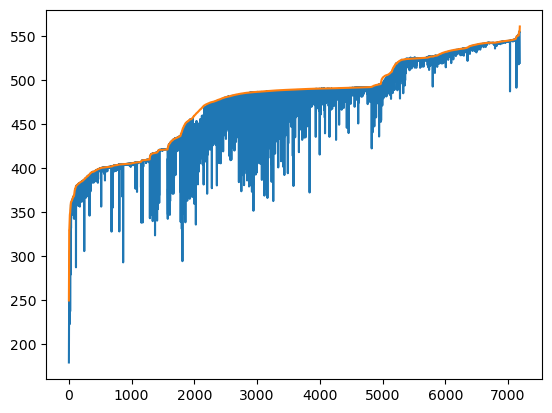

In [108]:
sorted_combinedGDF_comparison = combinedGDF_comparison.sort_values("AC_Shaded").reset_index(drop=True)
plt.plot(sorted_combinedGDF_comparison["AC_fine"])
plt.plot(sorted_combinedGDF_comparison["AC_Shaded"])

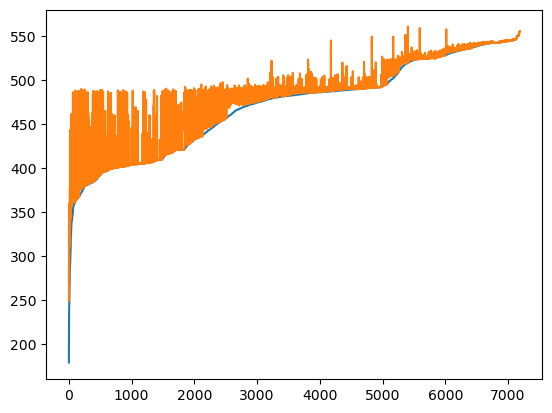

In [110]:
sorted_combinedGDF_comparison = combinedGDF_comparison.sort_values("AC_fine").reset_index(drop=True)
plt.plot(sorted_combinedGDF_comparison["AC_fine"])
plt.plot(sorted_combinedGDF_comparison["AC_Shaded"])

<BarContainer object of 10 artists>

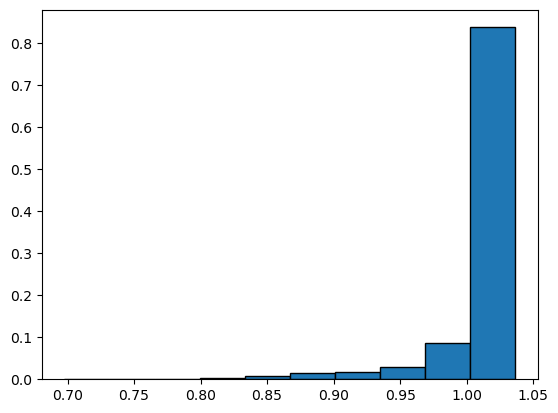

In [100]:
import numpy as np
hist, edges = np.histogram(combinedGDF_comparison["LossRatio"])
freq = hist / float(hist.sum())
width = np.diff(edges) # edges is bins
plt.bar(edges[1:], freq, width=width, align="edge", ec="k")

In [101]:
np.min(combinedGDF_comparison["LossRatio"])

0.6637481496788626

In [103]:
np.max(combinedGDF_comparison["LossRatio"])

1.0026755462931785

In [102]:
sorted_combinedGDF_comparison

,AC_Shaded,1,2,3,AC_fine,5,6,7,LossRatio
0,249.916455,266.328607,1631.084848,"POLYGON ((434260.478 4584731.822, 434259.827 4...",179.461910,193.285867,1182.191952,"POLYGON ((434260.478 4584731.822, 434259.827 4...",0.718088
1,257.544680,274.237060,1678.915629,"POLYGON ((434261.819 4584733.137, 434261.169 4...",208.392385,223.279123,1367.419255,"POLYGON ((434261.819 4584733.137, 434261.169 4...",0.809150
2,276.136063,293.511410,1794.577111,"POLYGON ((434263.161 4584734.453, 434262.511 4...",232.992733,248.783182,1521.872587,"POLYGON ((434263.161 4584734.453, 434262.511 4...",0.843761
3,311.086500,329.752999,2040.662125,"POLYGON ((434257.158 4584725.665, 434257.862 4...",244.221722,260.431899,1609.898542,"POLYGON ((434257.158 4584725.665, 434257.862 4...",0.785060
4,317.929173,336.847042,2084.582709,"POLYGON ((434256.455 4584724.98, 434257.158 45...",260.503594,277.311896,1715.410950,"POLYGON ((434256.455 4584724.98, 434257.158 45...",0.819376
...,...,...,...,...,...,...,...,...,...
7184,555.572398,583.213006,3564.956235,"POLYGON ((433999.097 4585267.775, 433998.434 4...",555.550872,583.190690,3564.768350,"POLYGON ((433999.097 4585267.775, 433998.434 4...",0.999961
7185,555.711378,583.346027,3565.793728,"POLYGON ((434006.996 4585259.731, 434006.333 4...",555.363509,582.980461,3562.894733,"POLYGON ((434006.996 4585259.731, 434006.333 4...",0.999374
7186,558.121463,585.858018,3580.271754,"POLYGON ((434043.238 4584894.181, 434043.226 4...",528.980555,555.646599,3404.427076,"POLYGON ((434043.238 4584894.181, 434043.226 4...",0.947788
7187,559.500175,587.287378,3588.760950,"POLYGON ((434045.117 4584894.157, 434045.105 4...",524.252409,550.744761,3375.698162,"POLYGON ((434045.117 4584894.157, 434045.105 4...",0.937001


# Plot planeID results

In [9]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_identified_planes(experimentPath, parcel, construction):
    parcelPath = experimentPath + "/" + parcel + "/"
    constructionPath = parcelPath + str(construction) + "/"
    gpkgPath = constructionPath + "Plane Identification/" + construction + ".gpkg"
    geoDF = gpd.read_file(gpkgPath)
    geoDF.plot(column = "silhouette", legend = True, edgecolor="black")
    plt.show()

def plot_identified_parcel(experimentPath, parcel):
    parcelPath = os.path.join(experimentPath, parcel)
    
    gpkg_paths = []
    for construction in [x for x in os.listdir(parcelPath) if os.path.isdir(os.path.join(parcelPath, x))]:
        gpkgPath = os.path.join(parcelPath, construction, "Plane Identification", f"{construction}.gpkg")
        if os.path.exists(gpkgPath):
            gpkg_paths.append(gpkgPath)
    
    # First pass: find global min and max
    min_val, max_val = float("inf"), float("-inf")
    for gpkgPath in gpkg_paths:
        geoDF = gpd.read_file(gpkgPath)
        if "silhouette" in geoDF.columns:
            min_val = min(min_val, geoDF["silhouette"].min())
            max_val = max(max_val, geoDF["silhouette"].max())
    min_val = 0
    
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    cmap = "inferno"  # you can change the colormap if you like

    fig, ax = plt.subplots(figsize=(10, 10))

    colors = [
        (228/255.0, 38/255.0, 38/255.0),  # red
        (1, 0.65, 0),                     # orange
        (137/255.0, 239/255.0, 73/255.0)  # green
    ]
    red_to_green = LinearSegmentedColormap.from_list("RedToGreen", colors)

    # Second pass: plot with shared colormap/norm
    for gpkgPath in gpkg_paths:
        geoDF = gpd.read_file(gpkgPath)
        if "silhouette" in geoDF.columns:
            geoDF.plot(
                column="silhouette",
                cmap=red_to_green,
                norm=norm,
                ax=ax,
                legend=False,  # disable per-layer legend,
                edgecolor="black"
            )
    
    # Add one shared colorbar
    sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=norm)
    sm._A = []  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Silhouette")
    
    plt.title(f"Identified Parcel: {parcel}")
    plt.show()

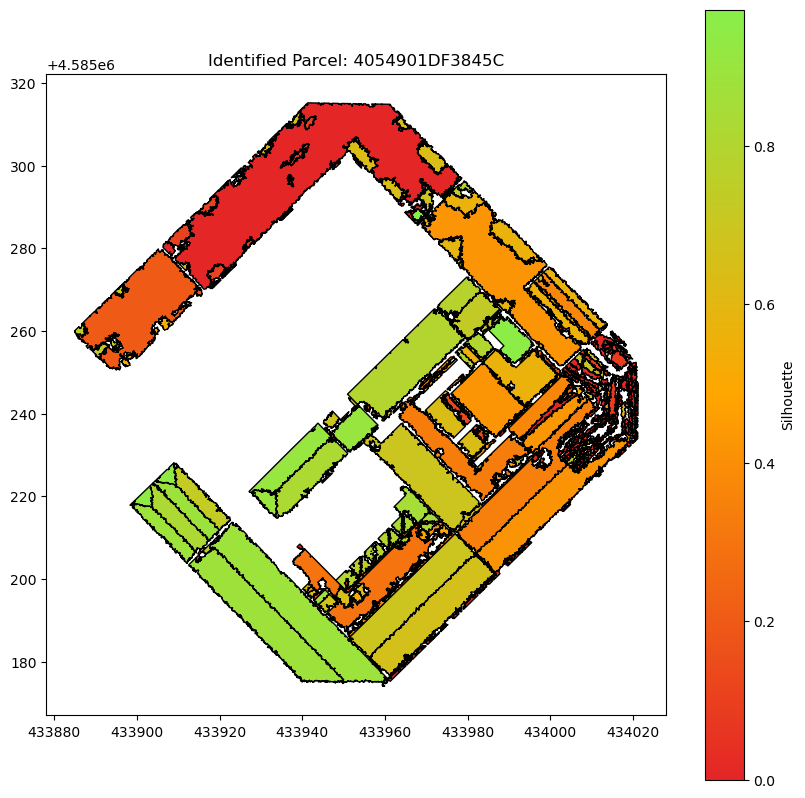

In [73]:
wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

experiment = "0_Results_for_paper_planeExtract_0p1_Shaded"

experimentPath = resultsPath + experiment
parcel = "4054901DF3845C"
construction = "115084364"

# plot_identified_planes(experimentPath, parcel, construction)
plot_identified_parcel(experimentPath, parcel)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

parcelsFolder = experimentPath + "/"

def plot_all_planeID(parcelsFolder, min_value=None):
    parcels = [parcel for parcel in os.listdir(parcelsFolder) if os.path.isdir(parcelsFolder + parcel)]
    num_parcels = len(parcels)

    grid_size = 3
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    colors = [(228/255.0, 38/255.0, 38/255.0), (1, 0.65, 0), (137/255.0, 239/255.0, 73/255.0)]
    red_to_green = LinearSegmentedColormap.from_list("RedToGreen", colors) #["red", "orange", "green"]
    if(min_value is None):
        min_silhouette = float('inf')  # Initialize with a very high value

        for parcel in parcels:
            parcelSubfolder = parcelsFolder + parcel + "/"

            for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
                constructionFolder = parcelSubfolder + construction
                planesPath = constructionFolder + "/Plane Identification/" + construction + ".gpkg"
                try:
                    planesGDF = gpd.read_file(planesPath)
                except:
                    print("ERROR")

                # Update the minimum silhouette score
                if "silhouette" in planesGDF.columns:
                    min_silhouette = min(min_silhouette, planesGDF["silhouette"].min())
    
    else:
        min_silhouette = min_value

    for idx, parcel in enumerate(parcels):
        row, col = divmod(idx, grid_size)  # Determine grid position
        ax = axes[row, col]  # Get the current subplot
        ax.set_title(f"{parcel}")

        parcelSubfolder = parcelsFolder + parcel + "/"

        constructions = [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]
        
        for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
            constructionFolder = parcelSubfolder + construction
            planesPath = constructionFolder + "/Plane Identification/" + construction + ".gpkg"
            try:
                planesGDF = gpd.read_file(planesPath)
            except:
                pass
            
            plot = planesGDF.plot(column="silhouette", edgecolor="black", cmap=red_to_green, legend=False, ax=ax, vmin=min_silhouette, vmax=1)

        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=True))
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

    fig.tight_layout()
    sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=plt.Normalize(vmin=min_silhouette, vmax=1))
    sm._A = []  # Required for ScalarMappable
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, location='right', pad=0.05, aspect=30) 
    cbar.set_label("Silhouette Score")

    plt.show()

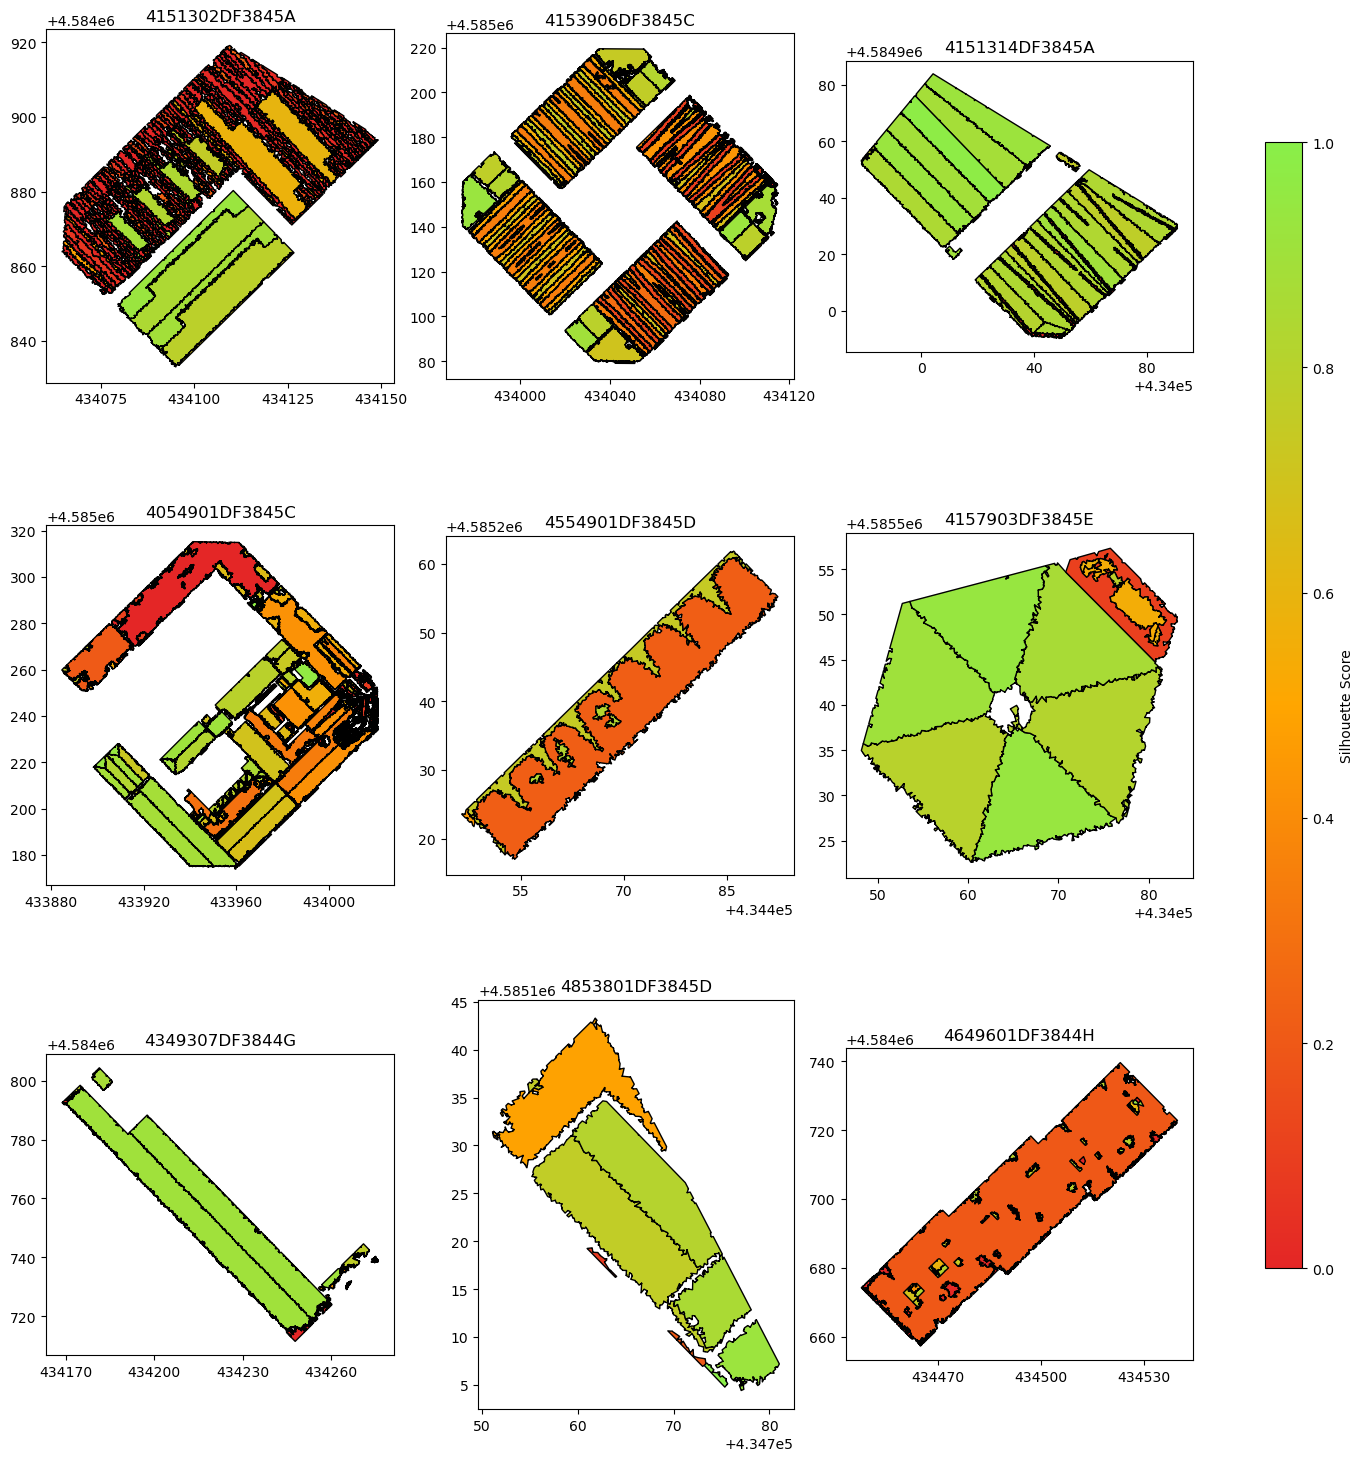

In [84]:
wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

experiment = "0_Results_for_paper_planeExtract_0p1_Shaded_30cmMesh"

experimentPath = resultsPath + experiment
parcelsFolder = experimentPath + "/"
plot_all_planeID(parcelsFolder)

# Get the absolute best

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [1]:
def group_by_constructions(metricsDF):
    result = (metricsDF.groupby(["parcel", "construction"]).apply(lambda g: pd.Series({
        "clusters": list(g["cluster"]), 
        "avg_silhouette": (g["silhouette"] * g["area"]).sum() / g["area"].sum() 
        }
        )).reset_index())
    return result

In [7]:
import warnings
warnings.filterwarnings("ignore")

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

expClass = "v2_planeExtract"
expList =  [x for x in os.listdir(resultsPath) if (os.path.isfile(resultsPath+x) and x.startswith(expClass) and x.endswith("Metrics.txt"))]
# expClass = "kPlanes"
# expList =  expList + [x for x in os.listdir(resultsPath) if (os.path.isfile(resultsPath+x) and x.startswith(expClass) and x.endswith("Metrics.txt"))]

metricsDF_list = []
for file in expList:
    absolutePath = resultsPath + file
    metricsDF = pd.read_csv(absolutePath)
    metricsDF = group_by_constructions(metricsDF)
    metricsDF["experiment"] = file.split("_")[0]
    metricsDF["fullName"] = file.replace("_Metrics.txt", "")
    metricsDF_list.append(metricsDF)

fullMetrics = pd.concat(metricsDF_list).reset_index(drop=True)
bestIdentifications = fullMetrics.loc[fullMetrics.groupby("construction")["avg_silhouette"].idxmax()]
bestIdentifications = bestIdentifications.sort_values("parcel").reset_index(drop=True)

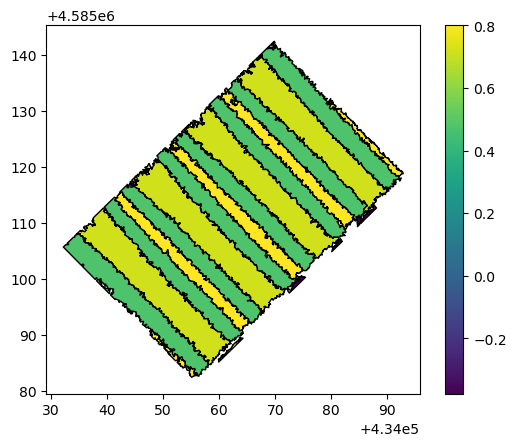

In [12]:
wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

idx = 29

experiment = bestIdentifications["fullName"][idx]
experimentPath = resultsPath + experiment
parcel = bestIdentifications["parcel"][idx]
construction = str(bestIdentifications["construction"][idx])

plot_identified_planes(experimentPath, parcel, construction)

In [15]:
from utils import create_output_folder
import shutil
targetFolder = resultsPath + "/Best_Identifications_v2_planeExtract/"
create_output_folder(targetFolder)

for idx, row in bestIdentifications.iterrows():
    sourceFolder = resultsPath + row["fullName"] + "/" + row["parcel"] + "/" + str(row["construction"])
    targetFolder = resultsPath + "/Best_Identifications_v2_planeExtract/" + row["parcel"] + "/" + str(row["construction"])
    try:
        shutil.copytree(sourceFolder, targetFolder)
    except FileExistsError:
        shutil.rmtree(targetFolder)
        shutil.copytree(sourceFolder, targetFolder)

In [16]:
bestIdentifications.to_csv(resultsPath + "/Best_Identifications_v2_planeExtract/BestID_Metrics.csv", index=None)

## Plot the absolute best

In [17]:
wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

experiment = "Best_Identifications_v2_planeExtract"

experimentPath = resultsPath + experiment
parcelsFolder = experimentPath + "/"
plot_all_planeID(parcelsFolder, min_value=0)

NameError: name 'plot_all_planeID' is not defined

## Plot the best with cadaster

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

parcelsFolder = experimentPath + "/"

def plot_all_planeID_Cadaster(parcelsFolder, min_value=None):
    parcels = [parcel for parcel in os.listdir(parcelsFolder) if os.path.isdir(parcelsFolder + parcel)]
    num_parcels = len(parcels)

    grid_size = 3
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    colors = [(228/255.0, 38/255.0, 38/255.0), (1, 0.65, 0), (137/255.0, 239/255.0, 73/255.0)]
    red_to_green = LinearSegmentedColormap.from_list("RedToGreen", colors) #["red", "orange", "green"]
    if(min_value is None):
        min_silhouette = float('inf')  # Initialize with a very high value

        for parcel in parcels:
            parcelSubfolder = parcelsFolder + parcel + "/"

            for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
                constructionFolder = parcelSubfolder + construction
                planesPath = constructionFolder + "/Plane Identification/" + construction + ".gpkg"
                try:
                    planesGDF = gpd.read_file(planesPath)
                except:
                    print("ERROR")

                # Update the minimum silhouette score
                if "silhouette" in planesGDF.columns:
                    min_silhouette = min(min_silhouette, planesGDF["silhouette"].min())
    
    else:
        min_silhouette = min_value

    for idx, parcel in enumerate(parcels):
        row, col = divmod(idx, grid_size)  # Determine grid position
        ax = axes[row, col]  # Get the current subplot
        ax.set_title(f"{parcel}")

        parcelSubfolder = parcelsFolder + parcel + "/"

        constructions = [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]
        
        for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
            constructionFolder = parcelSubfolder + construction
            planesPath = constructionFolder + "/Plane Identification/" + construction + ".gpkg"
            planesGDF = gpd.read_file(planesPath)
            
            plot = planesGDF.plot(column="silhouette", edgecolor="black", cmap=red_to_green, legend=False, ax=ax, vmin=min_silhouette, vmax=1)

            mapPath = constructionFolder + "/Map files/" + construction + ".gpkg"
            mapGDF = gpd.read_file(mapPath)
            plot = mapGDF.plot(facecolor="none", edgecolor="blue", linewidth=3, ax=ax)

        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=True))
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=True))
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

    fig.tight_layout()
    sm = plt.cm.ScalarMappable(cmap=red_to_green, norm=plt.Normalize(vmin=min_silhouette, vmax=1))
    sm._A = []  # Required for ScalarMappable
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8, location='right', pad=0.05, aspect=30) 
    cbar.set_label("Silhouette Score")

    plt.show()

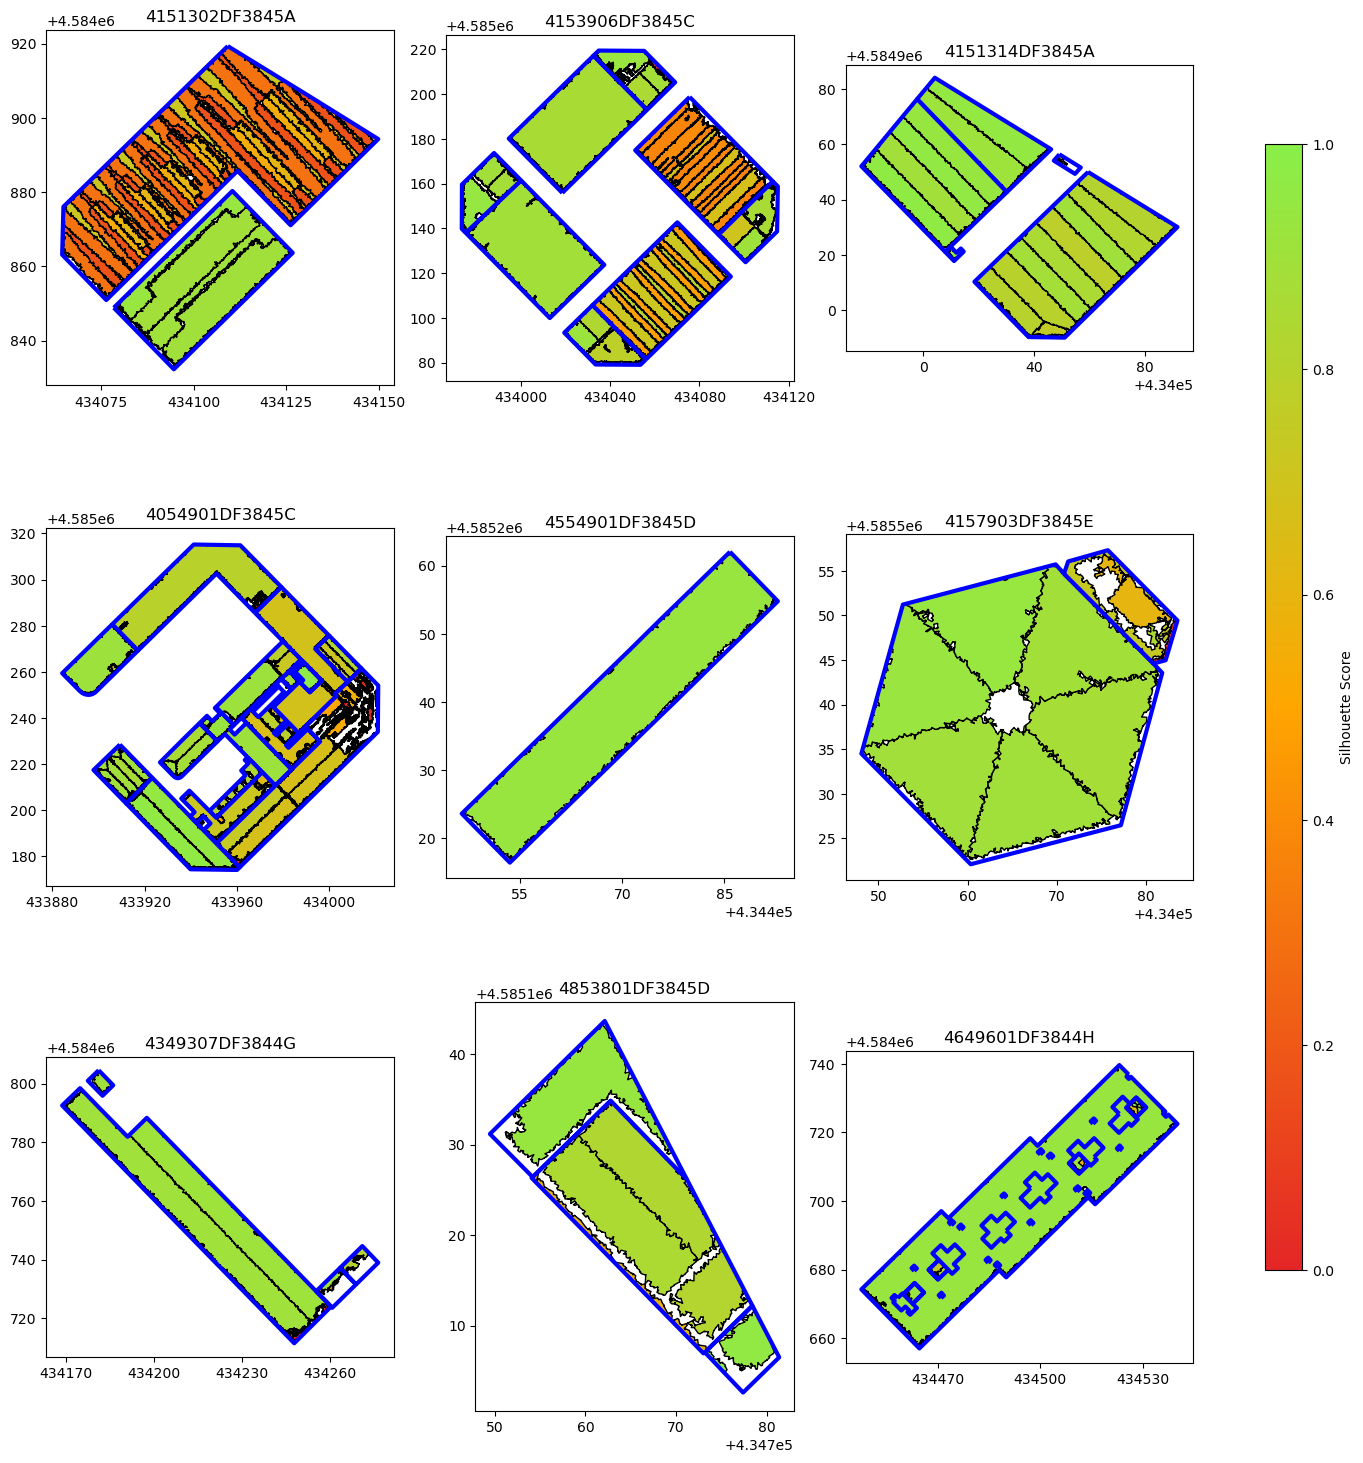

In [20]:
wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

experiment = "Best_Identifications_v2_planeExtract"

experimentPath = resultsPath + experiment
parcelsFolder = experimentPath + "/"
plot_all_planeID_Cadaster(parcelsFolder, min_value=0)

In [211]:
bestIdentifications.fullName

0     planeExtract_distance_threshold_0p5_inlierThre...
1     planeExtract_distance_threshold_0p5_inlierThre...
2     planeExtract_distance_threshold_0p5_inlierThre...
3     planeExtract_distance_threshold_0p5_inlierThre...
4     planeExtract_distance_threshold_0p5_inlierThre...
5     planeExtract_distance_threshold_0p5_inlierThre...
6     planeExtract_distance_threshold_0p5_inlierThre...
7     planeExtract_distance_threshold_0p5_inlierThre...
8     planeExtract_distance_threshold_0p5_inlierThre...
9     planeExtract_distance_threshold_0p5_inlierThre...
10    planeExtract_distance_threshold_0p5_inlierThre...
11    planeExtract_distance_threshold_0p5_inlierThre...
12    planeExtract_distance_threshold_0p5_inlierThre...
13    planeExtract_distance_threshold_0p5_inlierThre...
14    planeExtract_distance_threshold_0p5_inlierThre...
15    planeExtract_distance_threshold_0p5_inlierThre...
16    planeExtract_distance_threshold_0p5_inlierThre...
17    planeExtract_distance_threshold_0p5_inlier

# Material Adrià TFG

In [6]:
import os

targetBaseFolder = "/home/jaumeasensio/Downloads/Sample 50 edifics Adrià/"
parcelsFolder = resultsPath + "/Best_Identifications_planeExtract/"

for parcel in [x for x in os.listdir(parcelsFolder) if os.path.isdir(parcelsFolder + x)]:
    parcelSubfolder = parcelsFolder + parcel + "/"
    for construction in [x for x in os.listdir(parcelSubfolder) if os.path.isdir(parcelSubfolder + x)]:
        constructionFolder = parcelSubfolder + construction + "/"
        targetFolder = targetBaseFolder + "/" + construction + "/"
        sourceSubFolders = [constructionFolder + "Map files", constructionFolder + "Plane Identification", constructionFolder + "Shading"]
        targetSubFolders = [targetFolder + "Map files", targetFolder + "Plane Identification", targetFolder + "Shading"]
        for i in range(len(targetSubFolders)):
            try:
                shutil.copytree(sourceSubFolders[i], targetSubFolders[i])
            except FileExistsError:
                shutil.rmtree(targetSubFolders[i])
                shutil.copytree(sourceSubFolders[i], targetSubFolders[i])

In [23]:
import os
import shutil

wd = "/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version/"
resultsPath = wd + "/Results/"

parcelsFolder = resultsPath + "/0_Results_for_paper_planeExtract_0p1_Shaded/"
targetBaseFolder = resultsPath + "/Best_Identifications_v2_planeExtract/"

for parcel in [x for x in os.listdir(parcelsFolder) if os.path.isdir(parcelsFolder + x)]:
    parcelSubfolder = parcelsFolder + parcel + "/"
    for file in [x for x in os.listdir(parcelSubfolder) if os.path.isfile(parcelSubfolder + x)]:
        sourceFile = parcelSubfolder + file
        targetFile = targetBaseFolder + "/" + parcel + "/" + file
        
        shutil.copy(sourceFile, targetFile)

In [223]:
print(constructionFolder)
print(targetFolder)

/home/jaumeasensio/Documents/Projectes/BEEGroup/solar_potencial_estimation_v3/Final Version//Results//Best_Identifications_planeExtract/4649601DF3844H/115087390/
/home/jaumeasensio/Downloads/Sample 50 edifics Adrià/115087390


# Plots for paper

## Height Split

## Voronoi raw and clean

## Shading

### Overall

### Building 1

### Building 2

## Solar

## Boxplot experiments

## PlaneID results

## Shading histogram